In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-skin-lesion-dataset/Monkeypox_Dataset_metadata.csv
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M53_01_02.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_04.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_04_07.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_01_09.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_03_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_02_10.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M50_03_06.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M17_01_13.jpg
/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Val/Monkeypox/M34_02_10.jpg
/kaggle/input/monkeypox-s

In [28]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [30]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla T4


In [32]:
data_dir = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

In [31]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

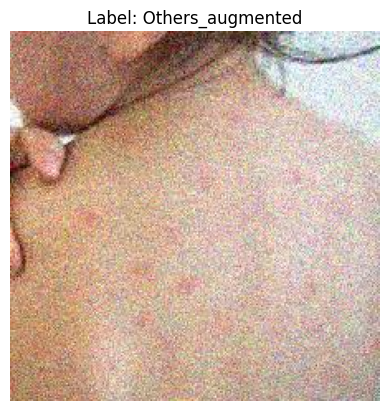

In [34]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

Class: Others_augmented, Count: 1764
Class: Monkeypox_augmented, Count: 1428


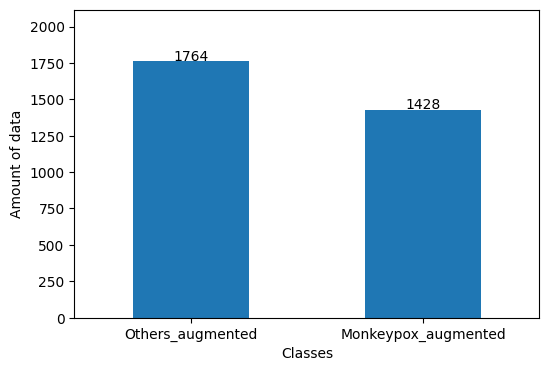

In [33]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

In [35]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [36]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  2234
Validation Data:  479
Test Data:  479
-------------------------------------------
Total amounts of data in the dataset:  3192


In [37]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                  Count
-------------------  -------
Others_augmented        1235
Monkeypox_augmented      999

Validation Dataset
Class                  Count
-------------------  -------
Others_augmented         265
Monkeypox_augmented      214

Test Dataset
Class                  Count
-------------------  -------
Others_augmented         264
Monkeypox_augmented      215


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [55]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Monkeypox_augmented': 0, 'Others_augmented': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)


In [56]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class myCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes)   

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))              
        x = self.fc2(x)                       
        return x

In [58]:
total_class = 2

model = myCNN(num_classes=total_class)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
myCNN                                    [32, 2]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─MaxPool2d: 1-2                         [32, 16, 112, 112]        --
├─Conv2d: 1-3                            [32, 32, 112, 112]        4,640
├─MaxPool2d: 1-4                         [32, 32, 56, 56]          --
├─Linear: 1-5                            [32, 128]                 12,845,184
├─Linear: 1-6                            [32, 2]                   258
Total params: 12,850,530
Trainable params: 12,850,530
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.99
Input size (MB): 19.27
Forward/backward pass size (MB): 308.31
Params size (MB): 51.40
Estimated Total Size (MB): 378.98

In [59]:
start_time = time.time()

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()



def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=20, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 70/70 [00:10<00:00,  6.79it/s, acc=0.599, loss=0.672]

Training Loss: 0.672 Acc: 0.599


Validation Loss: 0.655 Acc: 0.610
Best model saved at epoch 1 with validation accuracy: 0.610


Epoch 2/20: 100%|██████████| 70/70 [00:03<00:00, 23.20it/s, acc=0.669, loss=0.62] 

Training Loss: 0.620 Acc: 0.669


Validation Loss: 0.640 Acc: 0.647
Best model saved at epoch 2 with validation accuracy: 0.647


Epoch 3/20: 100%|██████████| 70/70 [00:03<00:00, 22.03it/s, acc=0.689, loss=0.601]

Training Loss: 0.601 Acc: 0.689


Validation Loss: 0.653 Acc: 0.628


Epoch 4/20: 100%|██████████| 70/70 [00:03<00:00, 21.02it/s, acc=0.714, loss=0.569]

Training Loss: 0.569 Acc: 0.714


Validation Loss: 0.624 Acc: 0.668
Best model saved at epoch 4 with validation accuracy: 0.668


Epoch 5/20: 100%|██████████| 70/70 [00:03<00:00, 22.01it/s, acc=0.736, loss=0.539]

Training Loss: 0.539 Acc: 0.736


Validation Loss: 0.611 Acc: 0.672
Best model saved at epoch 5 with validation accuracy: 0.672


Epoch 6/20: 100%|██████████| 70/70 [00:03<00:00, 22.43it/s, acc=0.756, loss=0.511]

Training Loss: 0.511 Acc: 0.756


Validation Loss: 0.672 Acc: 0.643


Epoch 7/20: 100%|██████████| 70/70 [00:03<00:00, 22.80it/s, acc=0.757, loss=0.494]

Training Loss: 0.494 Acc: 0.757


Validation Loss: 0.597 Acc: 0.668


Epoch 8/20: 100%|██████████| 70/70 [00:03<00:00, 21.99it/s, acc=0.785, loss=0.459]


Training Loss: 0.459 Acc: 0.785
Validation Loss: 0.597 Acc: 0.681
Best model saved at epoch 8 with validation accuracy: 0.681


Epoch 9/20: 100%|██████████| 70/70 [00:03<00:00, 22.94it/s, acc=0.787, loss=0.457]

Training Loss: 0.457 Acc: 0.787


Validation Loss: 0.584 Acc: 0.670


Epoch 10/20: 100%|██████████| 70/70 [00:03<00:00, 22.11it/s, acc=0.811, loss=0.418]

Training Loss: 0.418 Acc: 0.811


Validation Loss: 0.541 Acc: 0.697
Best model saved at epoch 10 with validation accuracy: 0.697


Epoch 11/20: 100%|██████████| 70/70 [00:03<00:00, 22.99it/s, acc=0.826, loss=0.39] 

Training Loss: 0.390 Acc: 0.826


Validation Loss: 0.523 Acc: 0.747
Best model saved at epoch 11 with validation accuracy: 0.747


Epoch 12/20: 100%|██████████| 70/70 [00:03<00:00, 22.10it/s, acc=0.843, loss=0.364]

Training Loss: 0.364 Acc: 0.843


Validation Loss: 0.576 Acc: 0.718


Epoch 13/20: 100%|██████████| 70/70 [00:03<00:00, 23.23it/s, acc=0.835, loss=0.382]

Training Loss: 0.382 Acc: 0.835


Validation Loss: 0.532 Acc: 0.722


Epoch 14/20: 100%|██████████| 70/70 [00:02<00:00, 23.44it/s, acc=0.868, loss=0.331]

Training Loss: 0.331 Acc: 0.868


Validation Loss: 0.506 Acc: 0.752
Best model saved at epoch 14 with validation accuracy: 0.752


Epoch 15/20: 100%|██████████| 70/70 [00:03<00:00, 23.17it/s, acc=0.876, loss=0.309]

Training Loss: 0.309 Acc: 0.876


Validation Loss: 0.490 Acc: 0.772
Best model saved at epoch 15 with validation accuracy: 0.772


Epoch 16/20: 100%|██████████| 70/70 [00:03<00:00, 23.16it/s, acc=0.88, loss=0.31]  

Training Loss: 0.310 Acc: 0.880


Validation Loss: 0.507 Acc: 0.783
Best model saved at epoch 16 with validation accuracy: 0.783


Epoch 17/20: 100%|██████████| 70/70 [00:03<00:00, 22.71it/s, acc=0.891, loss=0.282]

Training Loss: 0.282 Acc: 0.891


Validation Loss: 0.495 Acc: 0.777


Epoch 18/20: 100%|██████████| 70/70 [00:03<00:00, 23.11it/s, acc=0.902, loss=0.269]

Training Loss: 0.269 Acc: 0.902


Validation Loss: 0.479 Acc: 0.779


Epoch 19/20: 100%|██████████| 70/70 [00:03<00:00, 22.75it/s, acc=0.903, loss=0.255]

Training Loss: 0.255 Acc: 0.903


Validation Loss: 0.468 Acc: 0.789
Best model saved at epoch 19 with validation accuracy: 0.789


Epoch 20/20: 100%|██████████| 70/70 [00:03<00:00, 20.90it/s, acc=0.914, loss=0.24] 

Training Loss: 0.240 Acc: 0.914


Validation Loss: 0.515 Acc: 0.802
Best model saved at epoch 20 with validation accuracy: 0.802
Training Time: 91.99 seconds ---> 1.53 minutes


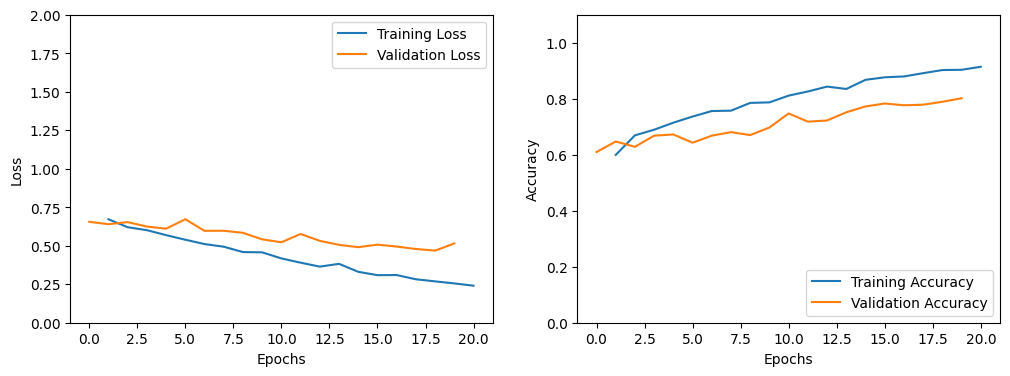

In [60]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [61]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [62]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 20) - Validation Loss: 0.515, Validation Accuracy: 0.802


In [63]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.827
Test Time: 2.33 seconds ---> 0.04 minutes


In [64]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       215
           1       0.86      0.81      0.84       264

    accuracy                           0.83       479
   macro avg       0.83      0.83      0.83       479
weighted avg       0.83      0.83      0.83       479

Class 0 Accuracy: 0.842
Class 1 Accuracy: 0.814
